In [1]:
import pickle
from pathlib import Path

import cv2
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt

pkl_name = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/test.pkl")

with open(pkl_name, "rb") as f:
    pkl_info = pickle.load(f)

In [2]:
def rgbtoint32(rgb):
    color = 0
    for c in rgb[::-1]:
        color = (color<<8) + c
        # Do not forget parenthesis.
        # color<< 8 + c is equivalent of color << (8+c)
    return color

def int32torgb(color):
    rgb = []
    for i in range(3):
        rgb.append(color&0xff)
        color = color >> 8
    return rgb

In [3]:
import numpy as np
from scipy.signal import hilbert

from Parsers.canonBinParser import readFileInfo, readIQ, iqToRf, getImage

In [4]:
folder = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/Preset_2/")
filePath = folder / pkl_info.imName

In [5]:
ImgData, ImgInfo, RefData, RefInfo = getImage(pkl_info.imName, "/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/Preset_2/", "20220831121752_IQ.bin", "/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom Data/Preset_2/")

/home/das/QuantUS_Projs/QuantUS/Parsers/canonBinParser.py:82: RuntimeWarning: divide by zero encountered in log10
  bmode = 20*np.log10(abs(iq))


Preset 2 found!
Preset 2 found!


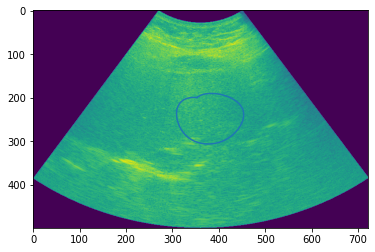

In [6]:
plt.imshow(ImgData.scBmodeStruct.scArr, aspect='auto')
plt.plot(pkl_info.finalSplineX, pkl_info.finalSplineY)

In [7]:
preScX = []; preScY = []
for x, y in zip(pkl_info.finalSplineX, pkl_info.finalSplineY):
    preScX.append(ImgData.scBmodeStruct.xmap[int(y), int(x)])
    preScY.append(ImgData.scBmodeStruct.ymap[int(y), int(x)])

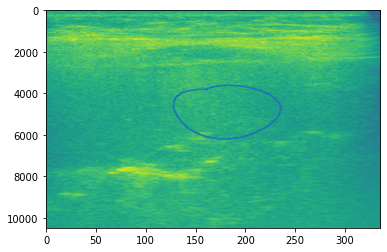

In [8]:
plt.imshow(ImgData.scBmodeStruct.preScArr, aspect='auto')
plt.plot(preScX, preScY)

In [9]:
from Utils.scRoiFuncs import roiWindowsGenerator

axResRF = 200 / ImgData.scBmodeStruct.preScArr.shape[0] # preset 2

windows = roiWindowsGenerator(preScX, preScY,
                            ImgData.scBmodeStruct.preScArr.shape[0], ImgData.scBmodeStruct.scArr.shape[1],
                            10, 10,
                            axResRF, axResRF*(ImgData.scBmodeStruct.preScArr.shape[0]/ImgData.scBmodeStruct.preScArr.shape[1]),
                            0, 0, 95)

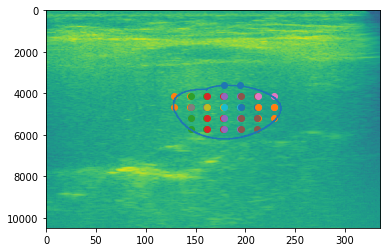

In [10]:
plt.imshow(ImgData.scBmodeStruct.preScArr, aspect='auto')
for left, right, top, bottom in zip(windows.left, windows.right, windows.top, windows.bottom):
    plt.scatter((left, left, right, right),
                (top, bottom, top, bottom))
plt.plot(preScX, preScY)

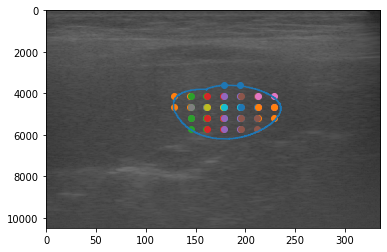

In [11]:
preScIm = cv2.cvtColor(np.array(ImgData.scBmodeStruct.preScArr).astype('uint8'), cv2.COLOR_GRAY2RGB)
plt.imshow(preScIm, aspect='auto')
for left, right, top, bottom in zip(windows.left, windows.right, windows.top, windows.bottom):
    plt.scatter((left, left, right, right),
                (top, bottom, top, bottom))
plt.plot(preScX, preScY)

In [12]:
from Utils.scRoiFuncs import computeSpecWindowsRF

imWinTopBottomDepth, imWinLeftRightWidth, imMbf, imSs, imSi, f, imNps = computeSpecWindowsRF(ImgData.rf, RefData.rf, windows.top, windows.bottom,
                          windows.left, windows.right, ImgInfo.minFrequency,
                          ImgInfo.maxFrequency, ImgInfo.lowBandFreq,
                          ImgInfo.upBandFreq, ImgInfo.samplingFrequency,
                          None, False)

In [13]:
preScIm.shape

(10472, 336, 3)

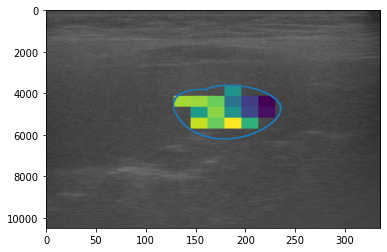

In [14]:
cmap = plt.get_cmap("viridis").colors

mbfPreScIm = preScIm.copy()

minMbf = min(imMbf)
maxMbf = max(imMbf)
for left, right, top, bottom, mbf in zip(windows.left, windows.right, windows.top, windows.bottom, imMbf):
    mbfPreScIm[top:bottom+1, left:right+1] = np.array(cmap[int((255 / (maxMbf-minMbf))*(mbf-minMbf))])*255

plt.imshow(mbfPreScIm, aspect='auto')
plt.plot(preScX, preScY)

In [24]:
condensed_arr = np.zeros((mbfPreScIm.shape[0], mbfPreScIm.shape[1])).astype('uint32')
for i in range(mbfPreScIm.shape[0]):
    for j in range(mbfPreScIm.shape[1]):
        condensed_arr[i, j] = rgbtoint32(mbfPreScIm[i,j])

for i in range(mbfPreScIm.shape[0]):
    for j in range(mbfPreScIm.shape[1]):
        mbfPreScIm[i, j] = int32torgb(condensed_arr[i,j])

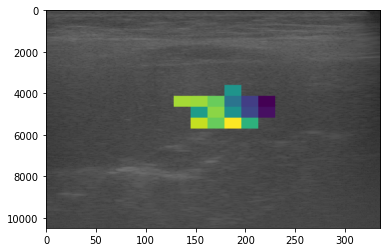

In [26]:
plt.imshow(mbfPreScIm, aspect='auto')

In [17]:
from Utils.parserTools import scanConvert

struct, hCm1, wCm1 = scanConvert(condensed_arr, ImgInfo.width1, ImgInfo.tilt1, ImgInfo.startDepth1, ImgInfo.endDepth1)

In [28]:
full_arr = np.zeros((struct.scArr.shape[0], struct.scArr.shape[1], 3))
for i in range(struct.scArr.shape[0]):
    for j in range(struct.scArr.shape[1]):
        full_arr[i,j] = int32torgb(struct.scArr[i,j])

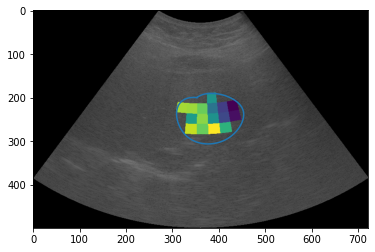

In [36]:
plt.imshow(full_arr.astype('uint8'), aspect='auto')
plt.plot(pkl_info.finalSplineX, pkl_info.finalSplineY)

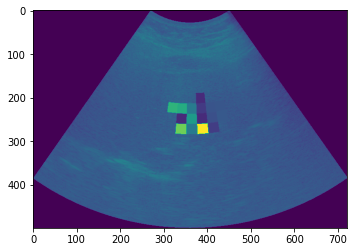

In [18]:
plt.imshow(struct.scArr)

In [65]:
np.array(ImgData.scBmodeStruct.preScArr).shape

(10472, 336)

In [30]:
inIm = preScIm; width = ImgInfo.width1; tilt = ImgInfo.tilt1; startDepth = ImgInfo.startDepth1
stopDepth = ImgInfo.endDepth1; desiredHeight = 500 

samples, beams = inIm.shape[:2]
depthIncrement = (stopDepth-startDepth)/(samples - 1)
startAngle = np.deg2rad(270 + tilt - width/2)
angleIncrement = np.deg2rad(width)/(beams-1)

outIm = inIm
background = 0
height = desiredHeight

# Subtract 180 degrees to get transudcer in top of image if startAngle > pi
startAngle = startAngle % np.pi
stopAngle = startAngle + np.deg2rad(width)
angleRange = np.arange(startAngle, stopAngle+angleIncrement, angleIncrement)

# Define physical limits of image
xmin = -1*max(np.cos(startAngle)*np.array([startDepth, stopDepth]))
xmax = -1*min(np.cos(stopAngle)*np.array([startDepth, stopDepth]))
ymin = min(np.sin(angleRange)*startDepth)
ymax = max(np.sin(angleRange)*stopDepth)
widthScale = abs((xmax-xmin)/(ymax-ymin))
width = int(np.ceil(height*widthScale))

heightCm = (ymax-ymin)*100
widthCm = (xmax-xmin)*100

# Make (x,y)-plane representation of physical image
xmat = (np.transpose(np.ones((1, height)))*np.arange(0, width, 1))/(width-1)
ymat = (np.transpose(np.arange(0, height, 1).reshape((1, height)))*np.ones((1, width)))/(height-1)
xmat = (xmat*(xmax-xmin)) + xmin
ymat = (ymat*(ymax-ymin)) + ymin

# Transform into polar coordinates (angle, range)
anglemat = np.arctan2(ymat, -1*xmat)
rmat = np.sqrt((xmat**2) + (ymat**2))

# Convert phys. angle and range into beam and sample
anglemat = np.ceil((anglemat - startAngle)/angleIncrement)
rmat = np.ceil((rmat - startDepth)/depthIncrement)

# Find pixels outside active sector
backgr = np.argwhere((rmat<1))
backgr = np.concatenate((backgr, np.argwhere(rmat>=samples)), axis=0)
backgr = np.concatenate((backgr, np.argwhere(anglemat<1)), axis=0)
backgr = np.concatenate((backgr, np.argwhere(anglemat>beams)), axis=0)
scMap = (anglemat-1)*samples + rmat

for i in range(backgr.shape[0]):
    scMap[backgr[i,0],backgr[i,1]] = background
inIm_indx = repmat(np.arange(0, outIm.shape[1]), int(outIm.shape[0]), 1) # <-- maps (y,x) in Iin to indt in Iin
inIm_indy = np.transpose(repmat(np.arange(0, outIm.shape[0]), int(outIm.shape[1]), 1)) # <-- maps (y,x) in Iout to indr in Iin
    
outIm = np.append(np.transpose(outIm), background)
# inIm_indy = np.append(np.transpose(inIm_indy), background)
# inIm_indx = np.append(np.transpose(inIm_indx), background)

# scMap = np.array(scMap).astype(np.uint64) - 1
# outIm = outIm[scMap, :]
# inIm_indy = inIm_indy[scMap]
# inIm_indx = inIm_indx[scMap]

# outIm = np.reshape(outIm, (height, width))
# inIm_indy = np.reshape(inIm_indy, (height, width))
# inIm_indx = np.reshape(inIm_indx, (height, width))

ValueError: setting an array element with a sequence.

In [29]:
outIm.shape

(10555777,)

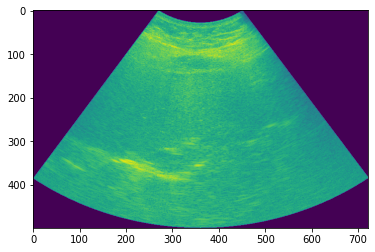

In [23]:
plt.imshow(outIm, aspect='auto')

In [372]:
np.amax(inIm_indy)
inIm.shape
np.amin(outIm)

0.0

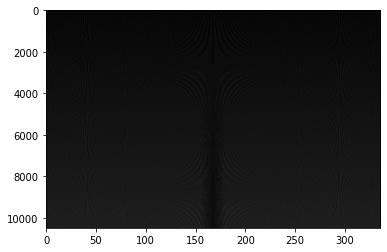

In [404]:
test = np.zeros_like(inIm)

for i in range(inIm_indx.shape[0]):
    for j in range(inIm_indy.shape[1]):
        test[inIm_indy[i,j], inIm_indx[i,j]] = 1#bmode[inIm_indy[i,j], inIm_indx[i,j]]

plt.imshow(np.clip(test, a_min=0, a_max=120), cmap="Greys_r", aspect='auto')

In [406]:
hi = np.where(test == 0)
len(hi[0])

3294930

In [402]:
np.amax(120-test)

120.0

/tmp/ipykernel_137084/789969773.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(inIm_indx, inIm_indy, outIm)


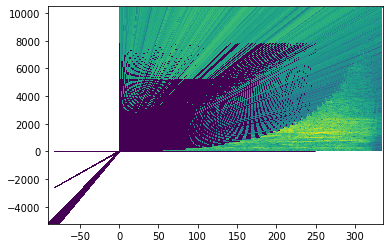

In [333]:
plt.pcolormesh(inIm_indx, inIm_indy, outIm)

In [247]:
scImMask = np.where(outIm > 0)

anglemat = anglemat*angleIncrement + startAngle
rmat = rmat*depthIncrement + startDepth

xmat = -rmat*np.cos(anglemat)
ymat = rmat*np.sin(anglemat)

xmat = (xmat-xmin) / (xmax-xmin) * (width-1)




# Make (x,y)-plane representation of physical image
xmat = (np.transpose(np.ones((1, height)))*np.arange(0, width, 1))/(width-1)
ymat = (np.transpose(np.arange(0, height, 1).reshape((1, height)))*np.ones((1, width)))/(height-1)
xmat = (xmat*(xmax-xmin)) + xmin
ymat = (ymat*(ymax-ymin)) + ymin

# Transform into polar coordinates (angle, range)
anglemat = np.arctan2(ymat, -1*xmat)
rmat = np.sqrt((xmat**2) + (ymat**2))

# Convert phys. angle and range into beam and sample
anglemat = np.ceil((anglemat - startAngle)/angleIncrement)
rmat = np.ceil((rmat - startDepth)/depthIncrement)

In [235]:
len(invScMap[0]) + 134487

361000

In [81]:
inIm = bmode; width = Info.width1; tilt = Info.tilt1; startDepth = Info.startDepth1
endDepth = Info.endDepth1; desiredHeight = 500 

In [82]:
width = np.deg2rad(width)
tilt = np.deg2rad(tilt)
frames = 1
samples, beams = inIm.shape

outIm = inIm; background = 0; transpose = 0; height = desiredHeight

startAngle = np.deg2rad(270) + tilt - width/2
stopAngle = startAngle + width
angleIncrement = width/(beams-1)
depthIncrement = (endDepth-startDepth)/(samples - 1)

stopDepth = (endDepth - startDepth)

angleRange = np.arange(startAngle, stopAngle+angleIncrement, angleIncrement)

#TODO: try all of these with values that make sense
xmin = -1*max(np.cos((startAngle%np.pi))*np.array([startDepth, stopDepth]))
xmax = -1*min(np.cos((stopAngle%np.pi))*np.array([startDepth, stopDepth]))
ymin = min(np.sin((angleRange%np.pi))*startDepth)
ymax = max(np.sin((angleRange%np.pi))*stopDepth)
widthScale = abs((xmax-xmin)/(ymax-ymin))

width = int(np.ceil(height*widthScale))

radI = 1
latI = 1
radSize = samples
latSize = beams

nr = (samples+((samples-1)*(radI-1)))
nb = (beams+((beams-1)*(latI-1)))
t0 = startAngle
dt = angleIncrement*(beams)/(nb)
r0 = startDepth
dr = depthIncrement*(samples)/(nr)
beams = nb
samples = nr
t0F = t0
dtF = dt
r0F = r0
drF = dr

# Subtract 180 degrees to get transudcer in top of image if startAngle > pi
t0 = t0 % np.pi
t0F = t0F % np.pi

# Define physical limits of image
stopAngle = t0 + (nb*dt)
stopDepth = r0 + (nr*dr)
angleRange = np.arange(t0, stopAngle+dt, dt)
y0 = min(r0*np.sin(angleRange))
ymax = max(stopDepth*np.sin(angleRange))
x0 = min([-1*stopDepth*np.cos(t0), -1*startDepth*np.cos(t0)])
xmax = max(-1*startDepth*np.cos(stopAngle), -1*stopDepth*np.cos(stopAngle))

heightCm = (ymax-y0)*100
widthCm = (xmax-x0)*100

In [83]:
xmax

0.11532026485499763

In [84]:
width

790

In [85]:
# Make (x,y)-plane representation of physical image
xmat = (np.transpose(np.ones((1, height)))*np.arange(0, width, 1))/(width-1)
ymat = (np.transpose(np.arange(0, height, 1).reshape((1, height)))*np.ones((1, width)))/(height-1)
xmat = (xmat*(xmax-x0)) + x0
ymat = (ymat*(ymax-y0)) + y0

In [86]:
# Transform into polar coordinates (angle, range)
anglemat = np.arctan2(ymat, -1*xmat)
rmat = np.sqrt((xmat**2) + (ymat**2))

In [87]:
# Find pixels outside active sector
backgr = np.argwhere((rmat<1))
backgr = np.concatenate((backgr, np.argwhere(rmat>=nrF)), axis=0)
backgr = np.concatenate((backgr, np.argwhere(anglemat<1)), axis=0)
backgr = np.concatenate((backgr, np.argwhere(anglemat>nbF)), axis=0)
scMap = (anglemat-1)*nrF + rmat

In [88]:
from numpy.matlib import repmat
# Mapping system added to Matlab by Ahmed El Kaffas - April 1st, 2019
for i in range(backgr.shape[0]):
    scMap[backgr[i,0],backgr[i,1]] = (nbF*nrF)+1
if np.amax(scMap)<((nbF*nrF)+1):
    scMap[0] = (nbF*nrF)+1
# inIm_indy = np.zeros(outIm.shape)
inIm_indx = repmat(np.arange(0, outIm.shape[1]), int(outIm.shape[0]), 1) # <-- maps (y,x) in Iin to indt in Iin
inIm_indy = np.transpose(repmat(np.arange(0, outIm.shape[0]), int(outIm.shape[1]), 1)) # <-- maps (y,x) in Iout to indr in Iin


In [89]:
outIm = np.append(np.transpose(outIm), background)

scMap = np.array(scMap).astype(np.uint64) - 1
outIm = outIm[scMap]

outIm = np.reshape(outIm, (height, width))

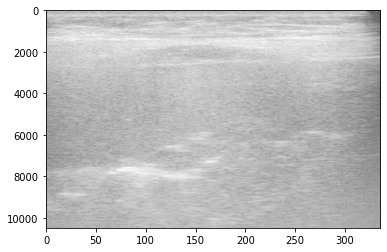

In [95]:
plt.imshow(inIm, aspect='auto', cmap="Greys_r")

In [ ]:
# Convert phys. angle and range into beam and sample
    anglemat = np.ceil((anglemat - t0F)/dtF)
    rmat = np.ceil((rmat - r0F)/drF)

In [44]:
polar_mesh = np.meshgrid(np.linspace(startAngle, stopAngle, beams),
                           np.linspace(startDepth, endDepth, samples))

In [47]:
polar_mesh[0]

array([[4.10152374, 4.1051707 , 4.10881766, ..., 5.31596031, 5.31960726,
        5.32325422],
       [4.10152374, 4.1051707 , 4.10881766, ..., 5.31596031, 5.31960726,
        5.32325422],
       [4.10152374, 4.1051707 , 4.10881766, ..., 5.31596031, 5.31960726,
        5.32325422],
       ...,
       [4.10152374, 4.1051707 , 4.10881766, ..., 5.31596031, 5.31960726,
        5.32325422],
       [4.10152374, 4.1051707 , 4.10881766, ..., 5.31596031, 5.31960726,
        5.32325422],
       [4.10152374, 4.1051707 , 4.10881766, ..., 5.31596031, 5.31960726,
        5.32325422]])

In [14]:
depthIncrement = (endDepth-startDepth)/(samples-1)

In [20]:
startAngle = np.deg2rad(270) + tilt - width/2
angleIncrement = width/(beams-1)

In [ ]:
outIm = inIm; background = 0; transpose = 0; height = desiredHeight; width = 0
stopAngle = startAngle + ((beams-1)*angleIncrement)
stopDepth = startDepth + ((samples-1)*depthIncrement)

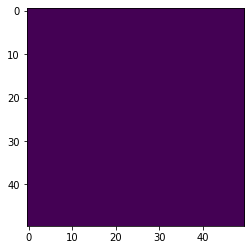

In [290]:
white = np.zeros((50, 50)).astype('uint8')-1
plt.imshow(white)

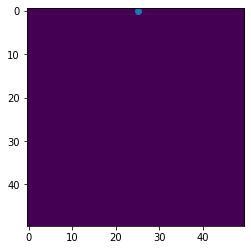

In [291]:
origin = (25, 0)
plt.imshow(white)
plt.scatter(origin[0], origin[1])

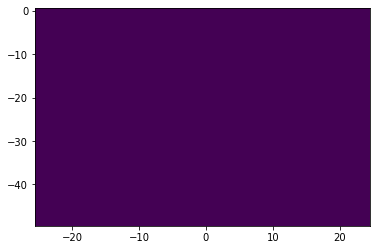

In [307]:
xmat, ymat = np.meshgrid(np.arange(white.shape[0]), np.arange(white.shape[1]))
xmat -= origin[0]
ymat -= np.amax(ymat)

plt.pcolormesh(xmat, ymat, white, edgecolors='face')

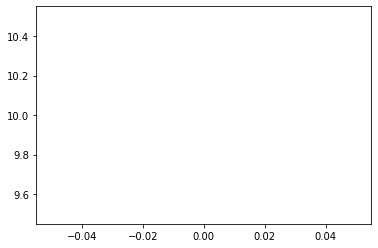

In [327]:
rmat = np.zeros_like(xmat) + 10
anglemat = np.zeros_like(xmat) + np.arange(0, np.pi, 50)

# # Convert phys. angle and range into beam and sample
# anglemat = np.ceil((anglemat - startAngle)/angleIncrement)
# rmat = np.ceil((rmat - startDepth)/depthIncrement)

plt.pcolormesh(anglemat, rmat, white*1000, edgecolors='black')

In [309]:
len(ymat)

50

In [284]:
white.shape

(50, 50, 3)

In [269]:
xmat[-1]

array([-0.11471529, -0.11439708, -0.11407886, -0.11376065, -0.11344244,
       -0.11312423, -0.11280602, -0.11248781, -0.11216959, -0.11185138,
       -0.11153317, -0.11121496, -0.11089675, -0.11057854, -0.11026032,
       -0.10994211, -0.1096239 , -0.10930569, -0.10898748, -0.10866927,
       -0.10835105, -0.10803284, -0.10771463, -0.10739642, -0.10707821,
       -0.10676   , -0.10644179, -0.10612357, -0.10580536, -0.10548715,
       -0.10516894, -0.10485073, -0.10453252, -0.1042143 , -0.10389609,
       -0.10357788, -0.10325967, -0.10294146, -0.10262325, -0.10230503,
       -0.10198682, -0.10166861, -0.1013504 , -0.10103219, -0.10071398,
       -0.10039576, -0.10007755, -0.09975934, -0.09944113, -0.09912292,
       -0.09880471, -0.09848649, -0.09816828, -0.09785007, -0.09753186,
       -0.09721365, -0.09689544, -0.09657723, -0.09625901, -0.0959408 ,
       -0.09562259, -0.09530438, -0.09498617, -0.09466796, -0.09434974,
       -0.09403153, -0.09371332, -0.09339511, -0.0930769 , -0.09